In [1]:
import logging
import os
from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import xgboost as xgb
import yaml
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from skopt import BayesSearchCV

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

MLFLOW_TRACKING_URI = 'http://localhost:5555'  # Optional: e.g., 'http://localhost:5555'
DATA_DIR_PROCESSED = Path('.').resolve().parent / "data" / "processed"

In [2]:
# Load data - numerical values as ints and categorical as category dtype (codes later)
data = pd.read_csv(DATA_DIR_PROCESSED / 
                   'clean_feature_process_ordinal_health_insurance_us_v1.csv', 
                   dtype={'age': 'int', 
                          'children': 'int',
                          'sex': 'category',
                          'smoker': 'category',
                          'region': 'category'})

data.sex = data.sex.cat.codes
data.smoker = data.smoker.cat.codes
data.region = data.region.cat.codes

X = data.drop(columns=['charges'], axis='columns')
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Dataset is fairly small in terms of size and dimensionality. **Recursive feature elimination (RFE)** maybe somewhat excessive. Such techniques are mainly relevant when you have 20+ features. RFE works by recursively removing the least important features based on the model's coefficients or feature importance scores until the desired number of features is reached.

Nevertheless, it can still be useful for identifying the most relevant features, initially via **feature importance** and then by **RFE**.

In [3]:
# Feature Importance using XGB Regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_importances = xgb_model.feature_importances_
xgb_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_importances})
xgb_importance_df = xgb_importance_df.sort_values(by='Importance', ascending=False)
xgb_importance_df

,Feature,Importance
4,smoker,0.934710
1,bmi,0.023396
0,age,0.018292
2,children,0.010160
5,region,0.007448
3,sex,0.005993


In [4]:
# Use XGBoost for RFE to stay consistent
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)

# RFE
rfe_selector = RFE(estimator=xgb_model, n_features_to_select=10)
rfe_selector.fit(X_train, y_train)
rfe_selected_features = X.columns[rfe_selector.support_]
rfe_ignored_features = X.columns[~rfe_selector.support_]

print("✅ Top 10 Selected Features by RFE:")
for feature in rfe_selected_features:
    print(f" - {feature}")

print("\n❌ Features Ignored by RFE:")
for feature in rfe_ignored_features:
    print(f" - {feature}")

# Store for config
selected_features_dict = {
    'rfe': list(rfe_selected_features)
}

# Filter datasets to use only selected features for experimentation
X_train = X_train[rfe_selected_features]
X_test = X_test[rfe_selected_features]

✅ Top 10 Selected Features by RFE:
 - age
 - bmi
 - children
 - sex
 - smoker
 - region

❌ Features Ignored by RFE:


/Users/ShuaibAhmed/Desktop/mlops-health-insurance-proj/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=10 > n_features=6. There will be no feature selection and all features will be kept.
  warnings.warn(


Now that the features have been selected, the next step is to experiment with different models and hyperparameters to identify the best-performing model for predicting insurance charges. This involves training various regression models, tuning their hyperparameters, and evaluating their performance using appropriate metrics.

**MLflow** will be used to track the experiments, log model parameters, and compare results. 

In [5]:
if MLFLOW_TRACKING_URI:
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    logger.info(f"MLflow Tracking URI set to: {MLFLOW_TRACKING_URI}")   
    mlflow.set_experiment("Health Insurance Charges Prediction")

INFO:root:MLflow Tracking URI set to: http://localhost:5555


In [6]:
# Define models and hyperparameters for grid search
models = {
    'LinearRegression': LinearRegression(),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

model_grids = {
    'LinearRegression': {},
    'SVR': {
        'C': [0.1, 1, 10],
        'epsilon': [0.1, 0.2, 0.5],
        'kernel': ['linear', 'rbf']
    },
    'RandomForestRegressor': {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20]
    },
    'XGBRegressor': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

In [7]:
def evaluate_model_with_grid_search(model_name, model, param_grid, X_train, y_train, X_test, y_test):
    if param_grid:
        clf = BayesSearchCV(model, param_grid, n_iter=10, cv=3, n_jobs=-1, random_state=42)
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_
        best_params = clf.best_params_
    else:
        model.fit(X_train, y_train)
        best_model = model
        best_params = best_model.get_params()

    y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        'model_name': model_name,
        'best_params': best_params,
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        'model': best_model
    }

print('MLFLOW_TRACKING_URI:', MLFLOW_TRACKING_URI)

MLFLOW_TRACKING_URI: http://localhost:5555


In [8]:
results = {} 

# Create separate MLflow runs for each model to avoid duplicate metric logging
for model_name, model in models.items():
    logger.info(f"Training and evaluating model: {model_name}")
    param_grid = model_grids.get(model_name, {})
    result = evaluate_model_with_grid_search(model_name, model, param_grid, X_train, y_train, X_test, y_test)
    results[model_name] = result

    # Create a separate MLflow run for each model
    if MLFLOW_TRACKING_URI:
        with mlflow.start_run(run_name=f"{model_name}_run"):
            # Log parameters with model name prefix to avoid conflicts
            prefixed_params = {f"{model_name}_{k}": v for k, v in result['best_params'].items()}
            mlflow.log_params(prefixed_params)
            
            # Log metrics with model name as tags for better organization
            mlflow.log_metrics({
                'mae': result['mae'],
                'mse': result['mse'],
                'rmse': result['rmse'],
                'r2': result['r2']
            })
            
            # Log additional info as tags
            mlflow.set_tag("model_type", model_name)
            mlflow.set_tag("experiment_type", "model_comparison")
            
            # Log the model with explicit artifact path
            try:
                mlflow.sklearn.log_model(
                    result['model'], 
                    artifact_path=f"{model_name}_model",
                    registered_model_name=None
                )
            except Exception as e:
                logger.warning(f"Failed to log model {model_name}: {str(e)}")
                # Continue with the loop even if model logging fails

    print(f"Model: {model_name} - MAE: {result['mae']:.2f}, MSE: {result['mse']:.2f}, RMSE: {result['rmse']:.2f}, R2: {result['r2']:.4f}")

INFO:root:Training and evaluating model: LinearRegression
/Users/ShuaibAhmed/Desktop/mlops-health-insurance-proj/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/ShuaibAhmed/Desktop/mlops-health-insurance-proj/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/ShuaibAhmed/Desktop/mlops-health-insurance-proj/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
2025/09/09 09:13:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/09 09:13:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/09 09:13:26 

🏃 View run LinearRegression_run at: http://localhost:5555/#/experiments/1/runs/fc4889d478284bfda862aa4c95c77bc6
🧪 View experiment at: http://localhost:5555/#/experiments/1
Model: LinearRegression - MAE: 4182.35, MSE: 35493102.61, RMSE: 5957.61, R2: 0.8068


2025/09/09 09:13:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/09 09:13:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/09 09:13:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:root:Training and evaluating model: RandomForestRegressor
/Users/ShuaibAhmed/Desktop/mlops-health-insurance-proj/.venv/lib/python3.12/site-packages/skopt/space/space.py:116: UserWarning: Dimension [50, 100] was inferred to Integer(low=50, high=100, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(50, 100), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/Users/ShuaibAhmed/Des

🏃 View run SVR_run at: http://localhost:5555/#/experiments/1/runs/a85385fa2b3f434eb6a439d5747854f1
🧪 View experiment at: http://localhost:5555/#/experiments/1
Model: SVR - MAE: 6977.60, MSE: 187461290.18, RMSE: 13691.65, R2: -0.0202


2025/09/09 09:13:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/09 09:13:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/09 09:13:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
INFO:root:Training and evaluating model: XGBRegressor
/Users/ShuaibAhmed/Desktop/mlops-health-insurance-proj/.venv/lib/python3.12/site-packages/skopt/space/space.py:116: UserWarning: Dimension [50, 100] was inferred to Integer(low=50, high=100, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(50, 100), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/Users/ShuaibAhmed/Desktop/mlop

🏃 View run RandomForestRegressor_run at: http://localhost:5555/#/experiments/1/runs/b262bc1373804b0f9f3659a78f25d3e4
🧪 View experiment at: http://localhost:5555/#/experiments/1
Model: RandomForestRegressor - MAE: 2537.50, MSE: 20861758.62, RMSE: 4567.47, R2: 0.8865


2025/09/09 09:13:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/09 09:13:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/09/09 09:13:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBRegressor_run at: http://localhost:5555/#/experiments/1/runs/9280f51317f141e88dc14f575520f985
🧪 View experiment at: http://localhost:5555/#/experiments/1
Model: XGBRegressor - MAE: 2540.43, MSE: 18750732.49, RMSE: 4330.21, R2: 0.8980


🏆 Model Performance Comparison (sorted by R2 score):
                Model       MAE            MSE       RMSE      R2
         XGBRegressor 2540.4262  18750732.4925  4330.2116  0.8980
RandomForestRegressor 2537.5014  20861758.6185  4567.4674  0.8865
     LinearRegression 4182.3532  35493102.6117  5957.6088  0.8068
                  SVR 6977.6045 187461290.1835 13691.6504 -0.0202

🥇 Best performing model: XGBRegressor (R2 = 0.8980)


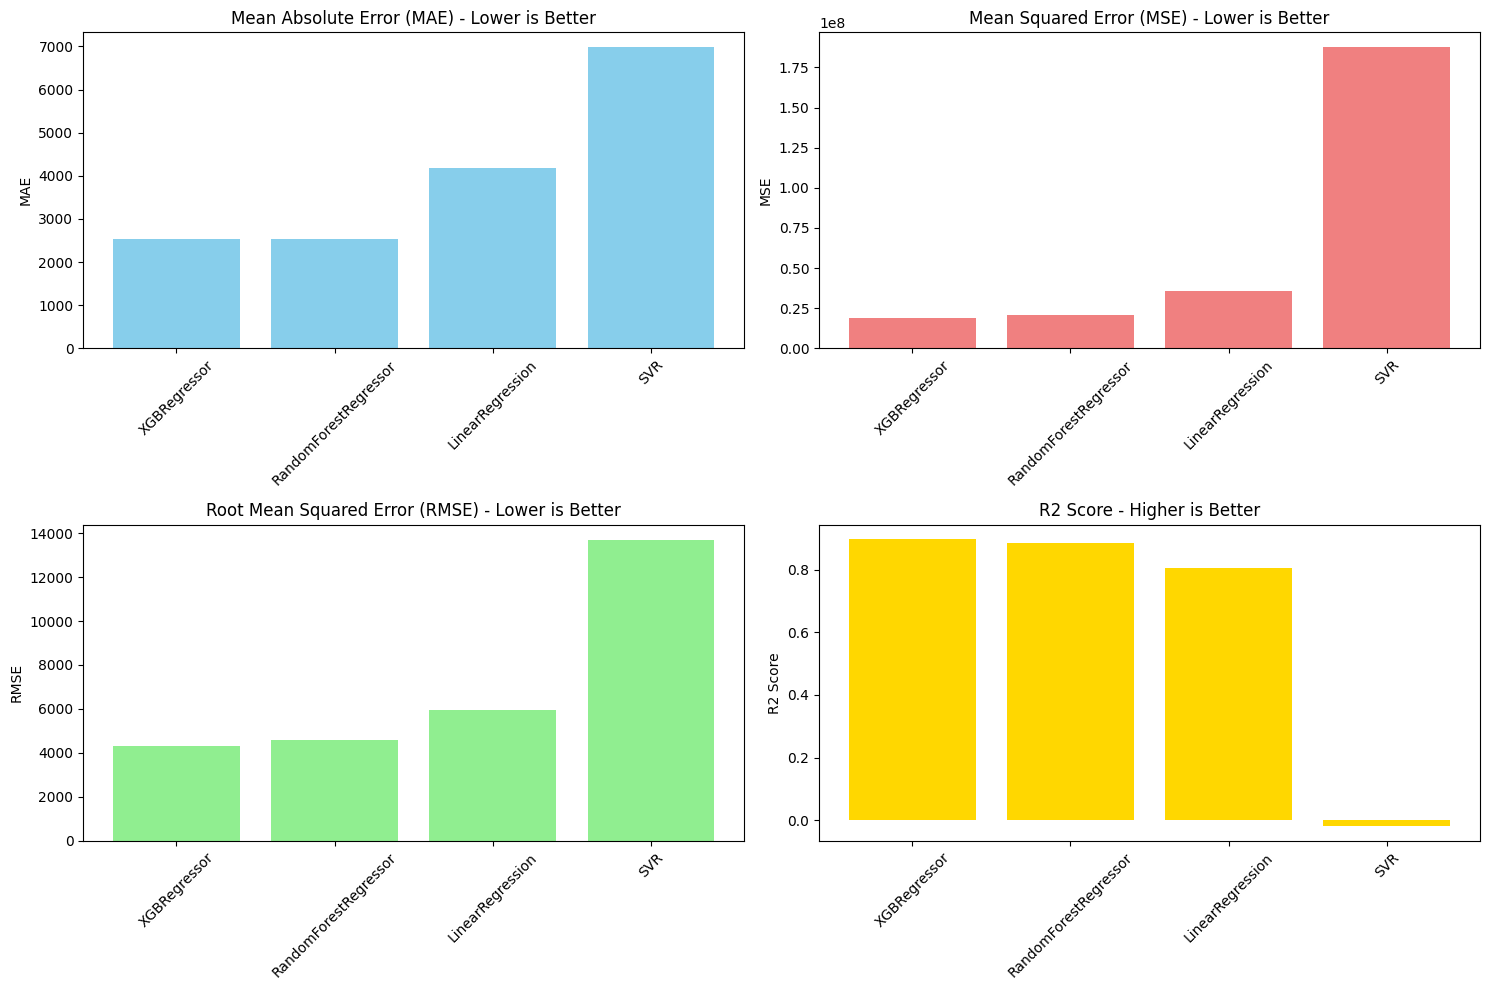

In [9]:
# Create a summary DataFrame for model comparison
model_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[model]['mae'] for model in results.keys()],
    'MSE': [results[model]['mse'] for model in results.keys()],
    'RMSE': [results[model]['rmse'] for model in results.keys()],
    'R2': [results[model]['r2'] for model in results.keys()]
})

# Sort by R2 score (descending - higher is better)
model_comparison = model_comparison.sort_values('R2', ascending=False).sort_values('RMSE', ascending=True)
print("🏆 Model Performance Comparison (sorted by R2 score):")
print("=" * 70)
print(model_comparison.to_string(index=False, float_format='%.4f'))

print(f"\n🥇 Best performing model: {model_comparison.iloc[0]['Model']} (R2 = {model_comparison.iloc[0]['R2']:.4f})")

# Visualize model comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# MAE comparison
ax1.bar(model_comparison['Model'], model_comparison['MAE'], color='skyblue')
ax1.set_title('Mean Absolute Error (MAE) - Lower is Better')
ax1.set_ylabel('MAE')
ax1.tick_params(axis='x', rotation=45)

# MSE comparison
ax2.bar(model_comparison['Model'], model_comparison['MSE'], color='lightcoral')
ax2.set_title('Mean Squared Error (MSE) - Lower is Better')
ax2.set_ylabel('MSE')
ax2.tick_params(axis='x', rotation=45)

# RMSE comparison
ax3.bar(model_comparison['Model'], model_comparison['RMSE'], color='lightgreen')
ax3.set_title('Root Mean Squared Error (RMSE) - Lower is Better')
ax3.set_ylabel('RMSE')
ax3.tick_params(axis='x', rotation=45)

# R2 comparison
ax4.bar(model_comparison['Model'], model_comparison['R2'], color='gold')
ax4.set_title('R2 Score - Higher is Better')
ax4.set_ylabel('R2 Score')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Results

- XGBRegressor is the best performing model with an R² score of 0.8980 and RMSE of 4330.2116
- RandomForestRegressor comes second with R² = 0.8831 and RMSE = 4578.3453
- LinearRegression shows decent performance with R² = 0.8068 and RMSE = 5957.6088
- SVR performs poorly with a negative R² = -0.0202 and RMSE = 13691.6504

In [10]:
# Save model config with selected features
# Display information about the best model
best_model_name = model_comparison.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_model_params = results[best_model_name]['best_params']
best_r2 = model_comparison.iloc[0]['R2']
best_mae = model_comparison.iloc[0]['MAE']
best_rmse = model_comparison.iloc[0]['RMSE']
best_mse = model_comparison.iloc[0]['MSE']

# Convert OrderedDict to regular dict for cleaner YAML output
best_model_params = {k: v for k, v in best_model_params.items()}

config_path = Path('.').resolve().parent / 'configs' / 'model_config.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)

# Create custom YAML format with manual formatting for specific fields
yaml_content = f"""model:
  best_model_name: 
    {best_model_name}
  best_model_params:
"""

# Add model parameters
for key, value in best_model_params.items():
    yaml_content += f"    {key}: {value}\n"

yaml_content += "  selected_features:\n"
# Add selected features
for feature in selected_features_dict['rfe']:
    yaml_content += f"    - {feature}\n"

yaml_content += f"""  target_variable: 
    {y.name}
  performance:
    r2: {float(best_r2)}
    mae: {float(best_mae)}
    rmse: {float(best_rmse)}
    mse: {float(best_mse)}
"""

config_path = Path('.').resolve().parent / 'configs' / 'model_config.yaml'
os.makedirs(os.path.dirname(config_path), exist_ok=True)
# Write the custom formatted YAML
with open(config_path, 'w') as file:
    file.write(yaml_content)

# print(f"✅ Model configuration saved to {config_path}")